In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 PyTorch device: {device}")

# הגדרת matplotlib לעברית
plt.rcParams['font.family'] = ['Arial Unicode MS', 'Tahoma', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# פונקציה מתוקנת לטעינת נתונים
def load_geophone_data():
    """טעינת כל קבצי הנתונים"""
    
    file_mapping = {
        'man.csv': 'human',
        'car.csv': 'vehicle', 
        'car2.csv': 'vehicle',
        'nothing.csv': 'quiet'
    }
    
    data_dict = {}
    labels_dict = {}
    
    print("🔄 טעינת קבצי נתונים...")
    
    for filename, label in file_mapping.items():
        try:
            # קריאת הקובץ
            df = pd.read_csv(filename, header=None)
            print(f"✅ נטען {filename}: {df.shape[0]} שורות, {df.shape[1]} עמודות")
            
            # המרה למערך numpy
            data_dict[filename] = df.values
            labels_dict[filename] = label
            
        except FileNotFoundError:
            print(f"❌ לא נמצא קובץ: {filename}")
        except Exception as e:
            print(f"❌ שגיאה בטעינת {filename}: {e}")
    
    return data_dict, labels_dict

def prepare_raw_data(data_dict, labels_dict, window_size_seconds=2, sample_rate=1000):
    """הכנת נתונים גולמיים עם חלונות זמן"""
    
    window_size = window_size_seconds * sample_rate  # 2000 דגימות
    
    raw_windows = []
    labels = []
    
    # חישוב מספר כולל של חלונות לtqdm
    total_windows = 0
    for filename, signal_data in data_dict.items():
        total_windows += (signal_data.shape[0] - window_size) // (window_size // 2)
    
    print(f"🔄 יצירת {total_windows} חלונות של {window_size_seconds} שניות...")
    
    with tqdm(total=total_windows, desc="עיבוד חלונות גולמיים") as pbar:
        for filename, signal_data in data_dict.items():
            label = labels_dict[filename]
            
            # חלונות עם overlap של 50%
            step_size = window_size // 2
            
            for start_idx in range(0, signal_data.shape[0] - window_size + 1, step_size):
                end_idx = start_idx + window_size
                window = signal_data[start_idx:end_idx]
                
                if window.shape[0] == window_size:
                    raw_windows.append(window)
                    labels.append(label)
                
                pbar.update(1)
                if pbar.n >= total_windows:
                    break
    
    return np.array(raw_windows), np.array(labels)

🔧 PyTorch device: cpu


In [2]:
def create_raw_cnn_model(input_shape, num_classes):
    """מודל CNN לנתונים גולמיים (2D: זמן × חיישנים)"""
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # הוספת dimension channel
        layers.Reshape(input_shape + (1,)),
        
        # CNN layers - רואה דפוסים בזמן ובין חיישנים
        layers.Conv2D(16, (5, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 1)),
        layers.BatchNormalization(),
        
        layers.Conv2D(32, (5, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 1)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 2), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 1)),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3, 2), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [3]:
def create_raw_1d_cnn_model(input_shape, num_classes):
    """מודל CNN 1D שמעבד כל חיישן בנפרד ואז מאחד"""
    
    # Input
    input_layer = layers.Input(shape=input_shape)  # (2000, num_sensors)
    
    # עיבוד כל חיישן בנפרד
    sensor_outputs = []
    
    for i in range(input_shape[1]):  # עבור כל חיישן
        # חילוץ חיישן בודד
        sensor_data = layers.Lambda(lambda x, idx=i: x[:, :, idx:idx+1])(input_layer)
        
        # CNN 1D על החיישן
        x = layers.Conv1D(32, 11, activation='relu', padding='same')(sensor_data)
        x = layers.MaxPooling1D(2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv1D(64, 7, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling1D()(x)
        
        sensor_outputs.append(x)
    
    # איחוד כל החיישנים
    if len(sensor_outputs) > 1:
        combined = layers.Concatenate()(sensor_outputs)
    else:
        combined = sensor_outputs[0]
    
    # Dense layers
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model


In [4]:
def train_raw_model(model_type='2d'):
    """אימון מודל על נתונים גולמיים"""
    
    print("🔄 שלב 1: אימון על נתונים גולמיים")
    print("=" * 50)
    
    # טעינת נתונים
    data_dict, labels_dict = load_geophone_data()
    
    if not data_dict:
        print("❌ לא נמצאו קבצי נתונים!")
        return None
    
    # הכנת נתונים גולמיים
    X_raw, y_raw = prepare_raw_data(data_dict, labels_dict, window_size_seconds=2)
    
    print(f"✅ נוצרו {len(X_raw)} חלונות גולמיים")
    print(f"📊 צורת חלון: {X_raw[0].shape}")
    print(f"📈 טווח ערכים: {X_raw.min():.4f} עד {X_raw.max():.4f}")
    
    # קידוד תוויות
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_raw)
    y_categorical = tf.keras.utils.to_categorical(y_encoded)
    
    print(f"🏷️ קטגוריות: {label_encoder.classes_}")
    
    # נורמליזציה
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    # חלוקת נתונים
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_categorical, 
        test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"📈 אימון: {X_train.shape[0]} דגימות")
    print(f"📉 בדיקה: {X_test.shape[0]} דגימות")
    
    # בניית מודל
    print(f"\n🏗️ בניית מודל CNN {model_type.upper()}...")
    if model_type == '2d':
        model = create_raw_cnn_model(X_train[0].shape, len(label_encoder.classes_))
    else:
        model = create_raw_1d_cnn_model(X_train[0].shape, len(label_encoder.classes_))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("📋 סיכום מודל נתונים גולמיים:")
    model.summary()
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
    
    # אימון
    print(f"\n🎯 אימון מודל נתונים גולמיים...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # הערכה
    print("\n📊 הערכת מודל נתונים גולמיים...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"🎯 דיוק מודל גולמי: {test_accuracy:.4f}")
    
    # תחזיות
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    print("\n📈 דוח ביצועים - מודל גולמי:")
    print(classification_report(
        y_test_classes, y_pred_classes, 
        target_names=label_encoder.classes_
    ))
    
    return {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'label_encoder': label_encoder,
        'predictions': (y_test_classes, y_pred_classes),
        'type': 'raw_' + model_type
    }

In [5]:
class GeophoneFeatureExtractor:
    def __init__(self, sample_rate=1000, window_size=2048, hop_length=512):
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.hop_length = hop_length
    
    def extract_mel_spectrogram(self, signal_data, channel=0):
        """חילוץ מל-ספקטוגרמה"""
        if channel >= signal_data.shape[1]:
            channel = 0
            
        mel_spec = librosa.feature.melspectrogram(
            y=signal_data[:, channel].astype(float),
            sr=self.sample_rate,
            n_mels=128,
            hop_length=self.hop_length,
            n_fft=self.window_size
        )
        
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    
    def extract_fft_features(self, signal_data):
        """חילוץ מאפיינים באמצעות FFT"""
        fft_features = []
        
        for i in range(signal_data.shape[1]):
            fft_vals = fft(signal_data[:, i])
            fft_magnitude = np.abs(fft_vals[:len(fft_vals)//2])
            
            features = [
                np.mean(fft_magnitude),
                np.std(fft_magnitude),
                np.max(fft_magnitude),
                np.sum(fft_magnitude),
                np.median(fft_magnitude),
                np.percentile(fft_magnitude, 75),
                np.percentile(fft_magnitude, 25)
            ]
            fft_features.extend(features)
        
        return np.array(fft_features)
    
    def extract_time_domain_features(self, signal_data):
        """חילוץ מאפיינים בתחום הזמן"""
        features = []
        
        for i in range(signal_data.shape[1]):
            channel_data = signal_data[:, i]
            
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.var(channel_data),
                np.max(channel_data),
                np.min(channel_data),
                np.ptp(channel_data),
                np.mean(np.abs(channel_data)),
                np.sqrt(np.mean(channel_data**2)),
            ])
            
            # Zero crossing rate
            zero_crossings = np.where(np.diff(np.signbit(channel_data)))[0]
            zcr = len(zero_crossings) / len(channel_data)
            features.append(zcr)
            
            # Spectral centroid
            try:
                spectral_centroid = librosa.feature.spectral_centroid(
                    y=channel_data.astype(float), sr=self.sample_rate
                )[0]
                features.append(np.mean(spectral_centroid))
            except:
                features.append(0)
        
        return np.array(features)


In [6]:
def prepare_advanced_data(data_dict, labels_dict, segment_length=2000):
    """הכנת נתונים עם מאפיינים מתקדמים"""
    
    extractor = GeophoneFeatureExtractor()
    
    spectrograms = []
    fft_features = []
    time_features = []
    labels = []
    
    total_segments = sum(signal_data.shape[0] // segment_length 
                        for signal_data in data_dict.values())
    
    print(f"🔄 עיבוד {total_segments} סגמנטים מתקדמים...")
    
    with tqdm(total=total_segments, desc="עיבוד מאפיינים מתקדמים") as pbar:
        for filename, signal_data in data_dict.items():
            label = labels_dict[filename]
            num_segments = signal_data.shape[0] // segment_length
            
            for i in range(num_segments):
                start_idx = i * segment_length
                end_idx = start_idx + segment_length
                segment = signal_data[start_idx:end_idx]
                
                if segment.shape[0] < segment_length:
                    pbar.update(1)
                    continue
                
                try:
                    mel_spec = extractor.extract_mel_spectrogram(segment, channel=0)
                    fft_feat = extractor.extract_fft_features(segment)
                    time_feat = extractor.extract_time_domain_features(segment)
                    
                    spectrograms.append(mel_spec)
                    fft_features.append(fft_feat)
                    time_features.append(time_feat)
                    labels.append(label)
                    
                except Exception as e:
                    print(f"שגיאה בעיבוד: {e}")
                
                pbar.update(1)
    
    return np.array(spectrograms), np.array(fft_features), np.array(time_features), np.array(labels)


In [7]:
def create_advanced_model(spectrogram_shape, fft_features_shape, time_features_shape, num_classes):
    """מודל מתקדם עם ספקטוגרמה + מאפיינים"""
    
    # Inputs
    spectrogram_input = layers.Input(shape=spectrogram_shape, name='spectrogram_input')
    fft_input = layers.Input(shape=(fft_features_shape,), name='fft_input')
    time_input = layers.Input(shape=(time_features_shape,), name='time_input')
    
    # CNN לספקטוגרמה
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(spectrogram_input)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.BatchNormalization()(x1)
    
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.BatchNormalization()(x1)
    
    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x1 = layers.Dense(256, activation='relu')(x1)
    x1 = layers.Dropout(0.3)(x1)
    
    # Dense למאפייני FFT
    x2 = layers.Dense(128, activation='relu')(fft_input)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.3)(x2)
    x2 = layers.Dense(64, activation='relu')(x2)
    
    # Dense למאפיינים בזמן
    x3 = layers.Dense(128, activation='relu')(time_input)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.3)(x3)
    x3 = layers.Dense(64, activation='relu')(x3)
    
    # איחוד
    combined = layers.Concatenate()([x1, x2, x3])
    combined = layers.Dense(512, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(256, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)
    
    output = layers.Dense(num_classes, activation='softmax')(combined)
    
    model = keras.Model(inputs=[spectrogram_input, fft_input, time_input], outputs=output)
    return model


In [8]:
def train_advanced_model():
    """אימון מודל מתקדם"""
    
    print("\n🔄 שלב 2: אימון מודל מתקדם")
    print("=" * 50)
    
    # טעינת נתונים
    data_dict, labels_dict = load_geophone_data()
    
    # הכנת מאפיינים מתקדמים
    spectrograms, fft_features, time_features, labels = prepare_advanced_data(data_dict, labels_dict)
    
    print(f"✅ נוצרו {len(spectrograms)} ספקטוגרמות מתקדמות")
    print(f"📊 צורת ספקטוגרמה: {spectrograms[0].shape}")
    
    # קידוד תוויות
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = tf.keras.utils.to_categorical(labels_encoded)
    
    # נורמליזציה
    scaler_fft = StandardScaler()
    scaler_time = StandardScaler()
    
    fft_features_normalized = scaler_fft.fit_transform(fft_features)
    time_features_normalized = scaler_time.fit_transform(time_features)
    
    # חלוקת נתונים
    (X_spec_train, X_spec_test, 
     X_fft_train, X_fft_test, 
     X_time_train, X_time_test, 
     y_train, y_test) = train_test_split(
        spectrograms, fft_features_normalized, time_features_normalized, labels_categorical,
        test_size=0.2, random_state=42, stratify=labels_encoded
    )
    
    # נורמליזציה של ספקטוגרמות
    X_spec_train = X_spec_train / 255.0
    X_spec_test = X_spec_test / 255.0
    
    if len(X_spec_train.shape) == 3:
        X_spec_train = np.expand_dims(X_spec_train, -1)
        X_spec_test = np.expand_dims(X_spec_test, -1)
    
    print(f"📈 נתוני אימון מתקדמים: ספקטוגרמות {X_spec_train.shape}")
    
    # בניית מודל
    print("\n🏗️ בניית מודל מתקדם...")
    model = create_advanced_model(
        X_spec_train[0].shape, 
        X_fft_train.shape[1], 
        X_time_train.shape[1], 
        len(label_encoder.classes_)
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("📋 סיכום מודל מתקדם:")
    model.summary()
    
    # אימון
    print("\n🎯 אימון מודל מתקדם...")
    callbacks = [
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=7)
    ]
    
    history = model.fit(
        [X_spec_train, X_fft_train, X_time_train], y_train,
        batch_size=32,
        epochs=100,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # הערכה
    print("\n📊 הערכת מודל מתקדם...")
    test_loss, test_accuracy = model.evaluate(
        [X_spec_test, X_fft_test, X_time_test], y_test, verbose=0
    )
    print(f"🎯 דיוק מודל מתקדם: {test_accuracy:.4f}")
    
    # תחזיות
    y_pred = model.predict([X_spec_test, X_fft_test, X_time_test], verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    print("\n📈 דוח ביצועים - מודל מתקדם:")
    print(classification_report(
        y_test_classes, y_pred_classes, 
        target_names=label_encoder.classes_
    ))
    
    return {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'label_encoder': label_encoder,
        'predictions': (y_test_classes, y_pred_classes),
        'type': 'advanced'
    }

In [9]:
def compare_results(results_list):
    """השוואת תוצאות המודלים השונים"""
    
    print("\n🏆 השוואת תוצאות")
    print("=" * 50)
    
    # יצירת טבלת השוואה
    comparison_data = []
    for result in results_list:
        if result:
            comparison_data.append({
                'מודל': result['type'],
                'דיוק': f"{result['test_accuracy']:.4f}",
                'דיוק %': f"{result['test_accuracy']*100:.2f}%"
            })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    
    # גרף השוואה
    if len(comparison_data) > 1:
        plt.figure(figsize=(10, 6))
        models = [item['מודל'] for item in comparison_data]
        accuracies = [float(item['דיוק']) for item in comparison_data]
        
        bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange'][:len(models)])
        plt.title('השוואת דיוק המודלים השונים', fontsize=16, fontweight='bold')
        plt.ylabel('דיוק')
        plt.xlabel('סוג מודל')
        plt.ylim(0, 1)
        
        # הוספת ערכים על העמודות
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # המלצות
    print("\n💡 מסקנות והמלצות:")
    if len(comparison_data) > 1:
        best_model = max(comparison_data, key=lambda x: float(x['דיוק']))
        print(f"🥇 המודל הטוב ביותר: {best_model['מודל']} עם דיוק של {best_model['דיוק %']}")
        
        worst_model = min(comparison_data, key=lambda x: float(x['דיוק']))
        improvement = (float(best_model['דיוק']) - float(worst_model['דיוק'])) * 100
        print(f"📈 שיפור של {improvement:.2f}% בין המודל הגרוע ביותר לטוב ביותר")


In [10]:
def run_full_comparison():
    """הרצת השוואה מלאה בין הגישות"""
    
    print("🚀 התחלת השוואה מקיפה - נתונים גולמיים vs מתקדם")
    print("=" * 60)
    
    results = []
    
    # שלב 1: מודל נתונים גולמיים 2D
    print("\n1️⃣ אימון מודל CNN 2D על נתונים גולמיים...")
    try:
        result_raw_2d = train_raw_model(model_type='2d')
        results.append(result_raw_2d)
    except Exception as e:
        print(f"❌ שגיאה במודל גולמי 2D: {e}")
    
    # שלב 2: מודל נתונים גולמיים 1D
    print("\n2️⃣ אימון מודל CNN 1D על נתונים גולמיים...")
    try:
        result_raw_1d = train_raw_model(model_type='1d')
        results.append(result_raw_1d)
    except Exception as e:
        print(f"❌ שגיאה במודל גולמי 1D: {e}")
    
    # שלב 3: מודל מתקדם
    print("\n3️⃣ אימון מודל מתקדם...")
    try:
        result_advanced = train_advanced_model()
        results.append(result_advanced)
    except Exception as e:
        print(f"❌ שגיאה במודל מתקדם: {e}")
    
    # השוואת תוצאות
    print("\n🔍 השוואת כל התוצאות...")
    compare_results(results)
    
    return results


In [11]:
def plot_model_comparison_detailed(results_list):
    """הצגת השוואה מפורטת של המודלים"""
    
    if len(results_list) < 2:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('השוואה מפורטת בין המודלים', fontsize=16, fontweight='bold')
    
    # גרף 1: דיוק
    axes[0, 0].bar([r['type'] for r in results_list if r], 
                   [r['test_accuracy'] for r in results_list if r],
                   color=['lightblue', 'lightgreen', 'orange'])
    axes[0, 0].set_title('דיוק המודלים')
    axes[0, 0].set_ylabel('דיוק')
    axes[0, 0].set_ylim(0, 1)
    
    # גרף 2: היסטוריית אימון (אם יש)
    for i, result in enumerate(results_list):
        if result and 'history' in result:
            history = result['history']
            if 'accuracy' in history.history:
                axes[0, 1].plot(history.history['accuracy'], 
                              label=f"{result['type']} - אימון", linewidth=2)
                if 'val_accuracy' in history.history:
                    axes[0, 1].plot(history.history['val_accuracy'], 
                                  label=f"{result['type']} - ולידציה", 
                                  linestyle='--', linewidth=2)
    
    axes[0, 1].set_title('התקדמות הדיוק במהלך האימון')
    axes[0, 1].set_xlabel('אפוק')
    axes[0, 1].set_ylabel('דיוק')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # גרף 3: מטריצות בלבול
    for i, result in enumerate(results_list[:2]):  # רק 2 ראשונים
        if result and 'predictions' in result:
            y_true, y_pred = result['predictions']
            cm = confusion_matrix(y_true, y_pred)
            
            im = axes[1, i].imshow(cm, interpolation='nearest', cmap='Blues')
            axes[1, i].set_title(f'מטריצת בלבול - {result["type"]}')
            
            # הוספת מספרים
            thresh = cm.max() / 2.
            for j in range(cm.shape[0]):
                for k in range(cm.shape[1]):
                    axes[1, i].text(k, j, format(cm[j, k], 'd'),
                                  ha="center", va="center",
                                  color="white" if cm[j, k] > thresh else "black")
    
    # הסתרת גרף רביעי אם אין צורך
    if len(results_list) < 3:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [12]:
def visualize_raw_data_samples():
    """הצגת דוגמאות מהנתונים הגולמיים"""
    
    print("📊 הצגת דוגמאות מהנתונים הגולמיים...")
    
    try:
        data_dict, labels_dict = load_geophone_data()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('דוגמאות מהנתונים הגולמיים (2000 דגימות ראשונות)', fontsize=16)
        
        axes = axes.flatten()
        
        for i, (filename, signal_data) in enumerate(data_dict.items()):
            if i >= 4:
                break
            
            # הצגת 3 חיישנים ראשונים
            sample_data = signal_data[:2000, :min(3, signal_data.shape[1])]
            
            for j in range(sample_data.shape[1]):
                axes[i].plot(sample_data[:, j], 
                           label=f'חיישן {j+1}', linewidth=1)
            
            axes[i].set_title(f'{labels_dict[filename]} - {filename}')
            axes[i].set_xlabel('זמן (דגימות)')
            axes[i].set_ylabel('אמפליטודה')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # סטטיסטיקות
            mean_val = np.mean(np.abs(sample_data))
            std_val = np.std(sample_data)
            axes[i].text(0.02, 0.98, f'ממוצע מוחלט: {mean_val:.4f}\nסטיית תקן: {std_val:.4f}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"שגיאה בהצגת נתונים גולמיים: {e}")


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.


🚀 פרויקט זיהוי צעדי אדם - השוואה מקיפה
מנתונים גולמיים לעיבוד מתקדם

📊 הצגת דוגמאות מהנתונים הגולמיים...
📊 הצגת דוגמאות מהנתונים הגולמיים...
🔄 טעינת קבצי נתונים...
❌ לא נמצא קובץ: man.csv
❌ לא נמצא קובץ: car.csv
❌ לא נמצא קובץ: car2.csv
❌ לא נמצא קובץ: nothing.csv


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

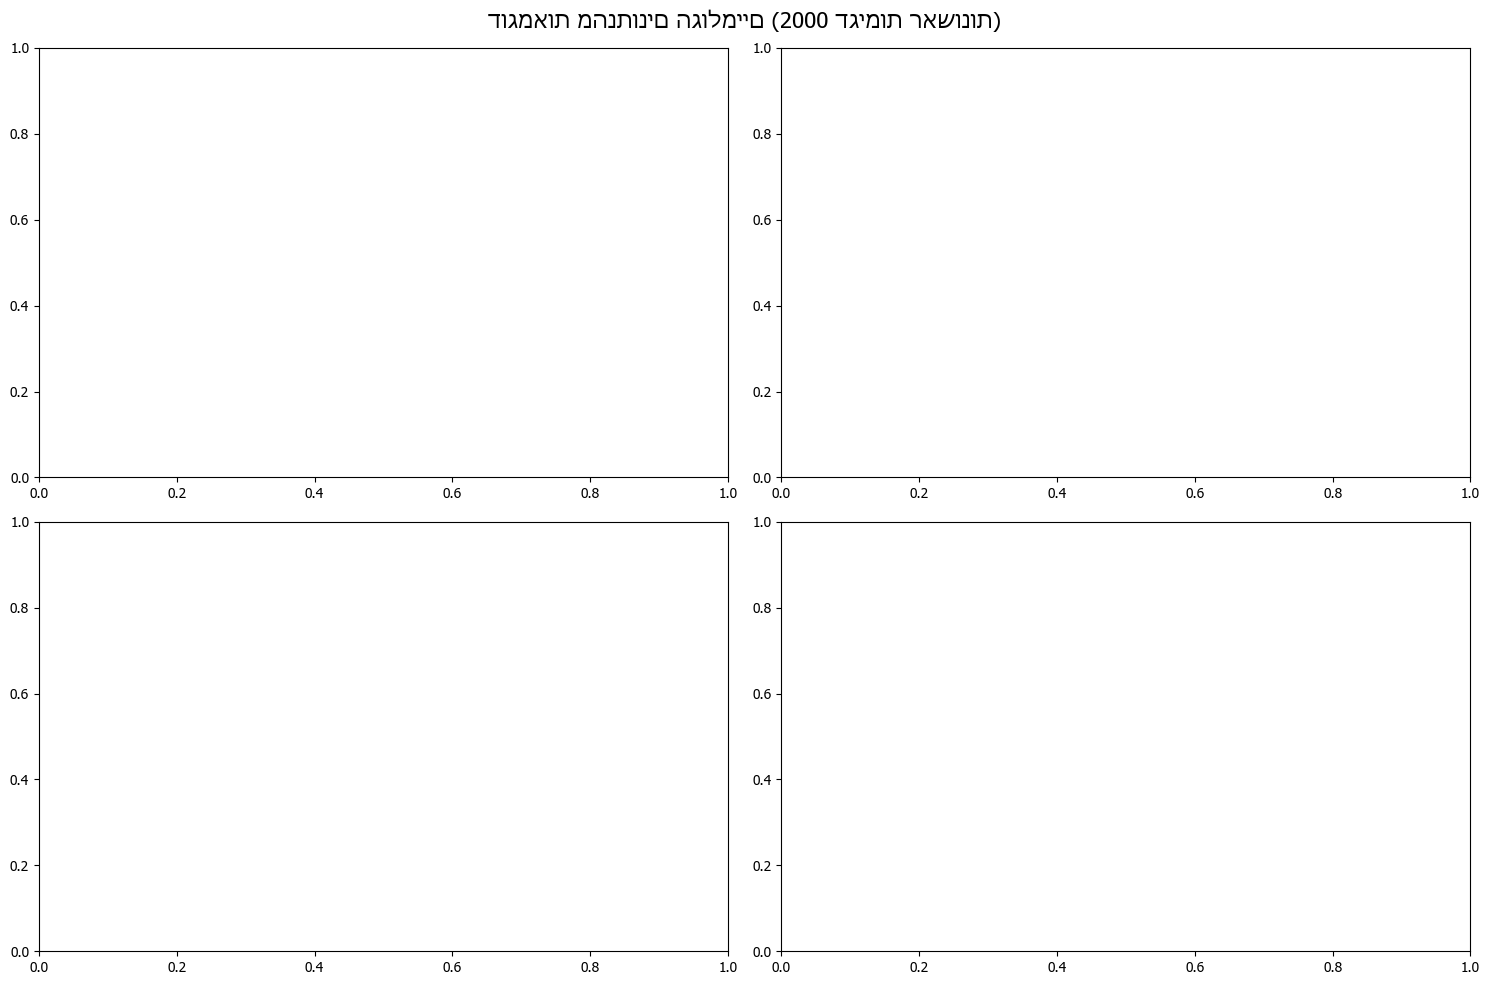


🔬 השוואת שיטות עיבוד...
🔬 השוואה בין עיבוד גולמי למתקדם...
🔄 טעינת קבצי נתונים...
❌ לא נמצא קובץ: man.csv
❌ לא נמצא קובץ: car.csv
❌ לא נמצא קובץ: car2.csv
❌ לא נמצא קובץ: nothing.csv
❌ לא נמצא קובץ צעדי אדם

🏃‍♂️ הרצת השוואה מלאה...
🚀 התחלת השוואה מקיפה - נתונים גולמיים vs מתקדם

1️⃣ אימון מודל CNN 2D על נתונים גולמיים...
🔄 שלב 1: אימון על נתונים גולמיים
🔄 טעינת קבצי נתונים...
❌ לא נמצא קובץ: man.csv
❌ לא נמצא קובץ: car.csv
❌ לא נמצא קובץ: car2.csv
❌ לא נמצא קובץ: nothing.csv
❌ לא נמצאו קבצי נתונים!

2️⃣ אימון מודל CNN 1D על נתונים גולמיים...
🔄 שלב 1: אימון על נתונים גולמיים
🔄 טעינת קבצי נתונים...
❌ לא נמצא קובץ: man.csv
❌ לא נמצא קובץ: car.csv
❌ לא נמצא קובץ: car2.csv
❌ לא נמצא קובץ: nothing.csv
❌ לא נמצאו קבצי נתונים!

3️⃣ אימון מודל מתקדם...

🔄 שלב 2: אימון מודל מתקדם
🔄 טעינת קבצי נתונים...
❌ לא נמצא קובץ: man.csv
❌ לא נמצא קובץ: car.csv
❌ לא נמצא קובץ: car2.csv
❌ לא נמצא קובץ: nothing.csv
🔄 עיבוד 0 סגמנטים מתקדמים...


עיבוד מאפיינים מתקדמים: 0it [00:00, ?it/s]

C:\Users\gil70\AppData\Local\Temp\ipykernel_12728\272239958.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.


✅ נוצרו 0 ספקטוגרמות מתקדמות
❌ שגיאה במודל מתקדם: index 0 is out of bounds for axis 0 with size 0

🔍 השוואת כל התוצאות...

🏆 השוואת תוצאות
Empty DataFrame
Columns: []
Index: []

💡 מסקנות והמלצות:

📈 ויזואליזציה מתקדמת...


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

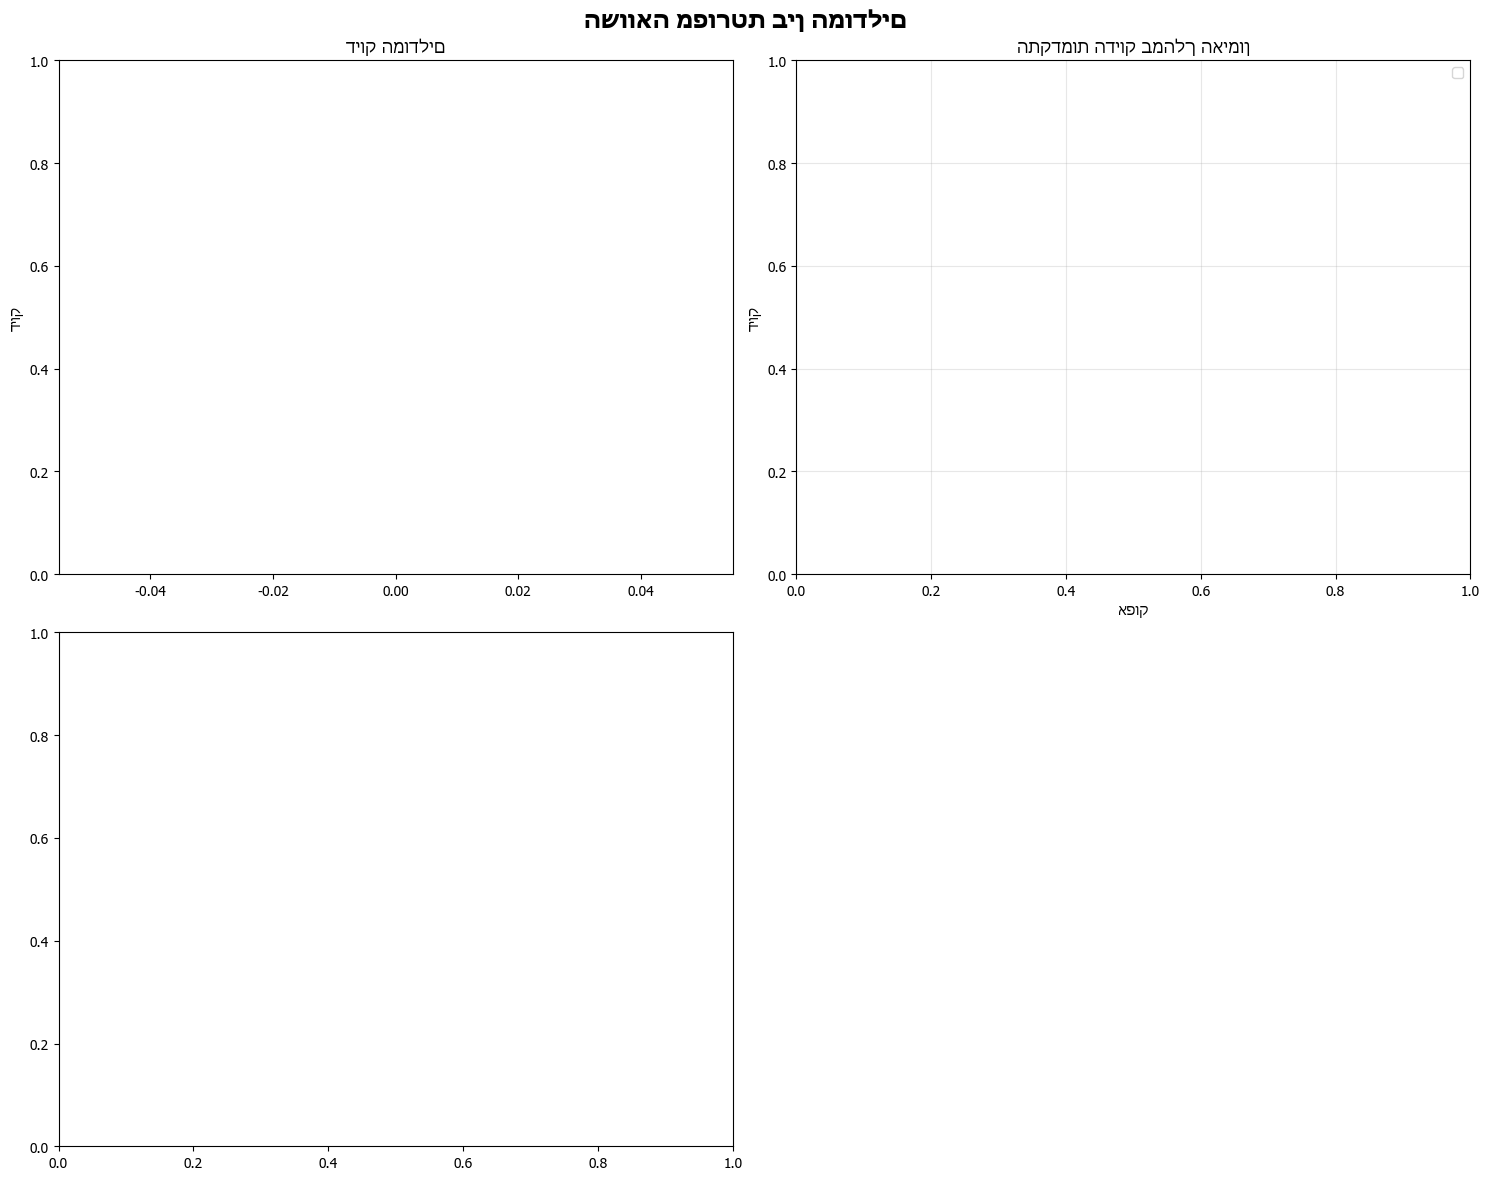

In [13]:
def show_data_preprocessing_comparison():
    """השוואה בין נתונים גולמיים למעובדים"""
    
    print("🔬 השוואה בין עיבוד גולמי למתקדם...")
    
    try:
        data_dict, labels_dict = load_geophone_data()
        
        # לקיחת דגימה מצעדי אדם
        man_data = None
        for filename, signal_data in data_dict.items():
            if 'man' in filename.lower():
                man_data = signal_data[:2000]  # 2 שניות
                break
        
        if man_data is None:
            print("❌ לא נמצא קובץ צעדי אדם")
            return
        
        # עיבוד מתקדם
        extractor = GeophoneFeatureExtractor()
        mel_spec = extractor.extract_mel_spectrogram(man_data, channel=0)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('השוואה: נתונים גולמיים vs מעובדים', fontsize=16)
        
        # נתונים גולמיים - חיישן ראשון
        axes[0, 0].plot(man_data[:, 0])
        axes[0, 0].set_title('נתונים גולמיים - חיישן 1')
        axes[0, 0].set_xlabel('זמן (דגימות)')
        axes[0, 0].set_ylabel('אמפליטודה')
        axes[0, 0].grid(True, alpha=0.3)
        
        # FFT של הנתונים הגולמיים
        fft_vals = fft(man_data[:, 0])
        freqs = fftfreq(len(man_data), 1/1000)
        axes[0, 1].plot(freqs[:len(freqs)//2], np.abs(fft_vals[:len(fft_vals)//2]))
        axes[0, 1].set_title('FFT של הנתונים הגולמיים')
        axes[0, 1].set_xlabel('תדר (הרץ)')
        axes[0, 1].set_ylabel('עוצמה')
        axes[0, 1].grid(True, alpha=0.3)
        
        # ספקטוגרמה מתקדמת
        librosa.display.specshow(mel_spec, sr=1000, hop_length=512, 
                                x_axis='time', y_axis='mel', ax=axes[1, 0])
        axes[1, 0].set_title('מל-ספקטוגרמה מתקדמת')
        
        # השוואת מאפיינים
        fft_features = extractor.extract_fft_features(man_data)
        time_features = extractor.extract_time_domain_features(man_data)
        
        axes[1, 1].bar(['FFT Features', 'Time Features'], 
                      [len(fft_features), len(time_features)],
                      color=['lightblue', 'lightgreen'])
        axes[1, 1].set_title('מספר מאפיינים מחולצים')
        axes[1, 1].set_ylabel('מספר מאפיינים')
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 מספר מאפייני FFT: {len(fft_features)}")
        print(f"⏰ מספר מאפיינים בזמן: {len(time_features)}")
        print(f"🎨 צורת ספקטוגרמה: {mel_spec.shape}")
        
    except Exception as e:
        print(f"שגיאה בהשוואת עיבוד: {e}")

def generate_improvement_recommendations(results_list):
    """יצירת המלצות לשיפור הביצועים"""
    
    print("\n🎯 המלצות לשיפור הביצועים")
    print("=" * 50)
    
    if not results_list:
        print("❌ אין תוצאות לניתוח")
        return
    
    # מציאת המודל הטוב ביותר
    best_result = max([r for r in results_list if r], key=lambda x: x['test_accuracy'])
    worst_result = min([r for r in results_list if r], key=lambda x: x['test_accuracy'])
    
    print(f"🏆 המודל הטוב ביותר: {best_result['type']} ({best_result['test_accuracy']:.4f})")
    print(f"📉 המודל הנמוך ביותר: {worst_result['type']} ({worst_result['test_accuracy']:.4f})")
    
    improvement_gap = best_result['test_accuracy'] - worst_result['test_accuracy']
    print(f"📈 פער שיפור: {improvement_gap:.4f} ({improvement_gap*100:.2f}%)")
    
    print("\n💡 המלצות ספציפיות:")
    
    # המלצות על בסיס התוצאות
    if best_result['test_accuracy'] < 0.7:
        print("🔴 דיוק נמוך - המלצות חירום:")
        print("   • בדוק איכות הנתונים ונקה רעש")
        print("   • הגדל את מקבץ הנתונים")
        print("   • נסה תכונות נוספות (MFCC, wavelet)")
        print("   • שקול data augmentation")
    
    elif best_result['test_accuracy'] < 0.85:
        print("🟡 דיוק בינוני - המלצות לשיפור:")
        print("   • כוונן היפר-פרמטרים")
        print("   • נסה ארכיטקטורות שונות")
        print("   • הוסף regularization")
        print("   • שפר את איכות המאפיינים")
    
    else:
        print("🟢 דיוק טוב - המלצות לאופטימיזציה:")
        print("   • אופטימיזציה של מהירות המודל")
        print("   • בדיקת robustness על נתונים חדשים")
        print("   • deploy ובדיקה בסביבה אמיתית")
    
    print("\n🔧 המלצות טכניות כלליות:")
    print("   • נסה ensemble של מספר מודלים")
    print("   • שקול transfer learning מתחומים דומים")
    print("   • בצע cross-validation מקיף")
    print("   • הוסף המשך ניטור ביצועים")
    
    print("\n📊 המלצות לנתונים:")
    print("   • אסוף נתונים נוספים במגוון תנאים")
    print("   • שפר את איכות התוויות")
    print("   • הוסף קטגוריות נוספות אם רלוונטי")
    print("   • בדוק איזון בין הקטגוריות")

# הרצת הפרויקט המלא
if __name__ == "__main__":
    print("🚀 פרויקט זיהוי צעדי אדם - השוואה מקיפה")
    print("מנתונים גולמיים לעיבוד מתקדם")
    print("=" * 60)
    
    # הצגת דוגמאות מהנתונים
    print("\n📊 הצגת דוגמאות מהנתונים הגולמיים...")
    visualize_raw_data_samples()
    
    # השוואת עיבוד נתונים
    print("\n🔬 השוואת שיטות עיבוד...")
    show_data_preprocessing_comparison()
    
    # הרצת השוואה מלאה
    print("\n🏃‍♂️ הרצת השוואה מלאה...")
    results = run_full_comparison()
    
    # ויזואליזציה מתקדמת
    if results:
        print("\n📈 ויזואליזציה מתקדמת...")
        plot_model_comparison_detailed(results)